<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_3Hweek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [2]:
!pip install datasets transformers[sentencepiece] kaggle

# Kaggle API Key 설정
import os
os.environ['KAGGLE_USERNAME'] = "sypark20" # Kaggle username 입력
os.environ['KAGGLE_KEY'] = "cc7952d167c6538e42c3f9d9a75d6f18" # Kaggle API key 입력

# 데이터셋 다운로드
!kaggle datasets download -d devicharith/language-translation-englishfrench

# 압축 해제
!unzip language-translation-englishfrench.zip

Dataset URL: https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench
License(s): CC0-1.0
100% 3.51M/3.51M [00:01<00:00, 3.88MB/s]
100% 3.51M/3.51M [00:01<00:00, 2.88MB/s]
Archive:  language-translation-englishfrench.zip
  inflating: eng_-french.csv         


## [MY CODE] BERT

In [ ]:
import torch
import pandas as pd
import kagglehub
from datasets import load_dataset
from torch.utils.data import DataLoader

# Download latest version
path = kagglehub.dataset_download("devicharith/language-translation-englishfrench")

# 데이터 불러오기
df = pd.read_csv(path + '/eng_-french.csv')  # 파일 경로 수정

# 필요한 열만 선택
df = df[['English words/sentences', 'French words/sentences']]

# 열 이름 변경
df.columns = ['en', 'fr']

# 데이터셋 분리
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 학습 데이터 줄이기
train_df = train_df.sample(frac=0.15, random_state=42)  # 15%만 사용
val_df = val_df.sample(frac=0.15, random_state=42)  # 15%만 사용

# Hugging Face Datasets으로 변환
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# 토크나이저 불러오기
from transformers import AutoTokenizer
model_checkpoint = "bert-base-multilingual-cased"  # For BERT
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', model_checkpoint)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [ ]:

def collate_fn(batch):
  max_len = 512
  texts, targets = [], []
  for row in batch:
    targets.append(row['fr'])
    texts.append(row['en'])

  tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  targets = torch.LongTensor([tokenizer(targets, padding=True, truncation=True, max_length=max_len).input_ids[0] for target in targets])


  return texts, targets


train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn
)

이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [ ]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [ ]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    self.classifier = nn.Linear(768, 1)

  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']
    x = self.classifier(x)

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [ ]:
from torch.optim import Adam
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCELoss()

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = preds[:, 0]  # [CLS] 토큰 예측 가져오기
    preds = F.sigmoid(preds) # 시그모이드 함수 적용

    # Ensure labels are floats and between 0 and 1
    labels = labels[:, 0].float()
    # Clamp labels to be between 0 and 1 to avoid assertion errors
    labels = torch.clamp(labels, 0, 1)

    loss = loss_fn(preds.squeeze(1), labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


KeyboardInterrupt: 

In [ ]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        preds = (preds > 0).long() # 0 또는 1 값을 가지는 텐서로 변환
        labels = labels.view(-1) # labels를 1차원으로 변환

        min_len = min(preds.shape[0], labels.shape[0])  # 최소 길이 계산
        cnt += labels.shape[0]
        acc += (labels[:min_len] == preds[:min_len, 0]).sum().item()  # Compare elements up to min_len

    return acc / cnt


with torch.no_grad():
  model.eval()
  train_acc = accuracy(model, train_loader)
  test_acc = accuracy(model, test_loader)
  print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Loss가 잘 떨어지고, 이전에 우리가 구현한 Transformer보다 더 빨리 수렴하는 것을 알 수 있습니다.

## [MY CODE[ Pre-trained 모델 선정
 - Helsinki-NLP/opus-mt-en-fr: 번역 작업에 적합 (seq2seq 모델)

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import kagglehub
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# 번역을 위한 모델 클래스 정의
class TranslationModel(torch.nn.Module):
    def __init__(self, model_checkpoint):
        super().__init__()
        # Seq2Seq 모델을 로드 (번역용)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None):
        # 모델 출력을 반환 (디코더 입력도 포함)
        return self.model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)

# 데이터 전처리 함수
def preprocess_data(df, tokenizer, max_length=128):
    def encode(row):
        # 영어 텍스트를 토크나이즈하여 번역할 준비
        encoded = tokenizer(row['en'], max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
        target_encoded = tokenizer(row['fr'], max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'decoder_input_ids': target_encoded['input_ids'].squeeze(0),  # 프랑스어 문장을 디코더 입력으로
            'target_text': row['fr']  # 실제 프랑스어 문장을 반환
        }
    return [encode(row) for _, row in df.iterrows()]

In [4]:
# 데이터셋 로드 및 전처리
path = kagglehub.dataset_download("devicharith/language-translation-englishfrench")

# 데이터 불러오기
df = pd.read_csv(path + '/eng_-french.csv')  # 파일 경로 수정

# 필요한 열만 선택
df = df[['English words/sentences', 'French words/sentences']]

# 열 이름 변경
df.columns = ['en', 'fr']

# 데이터셋 분리
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 번역 모델에 적합한 모델 및 토크나이저 선택
model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"  # 영어에서 프랑스어로 번역하는 모델
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_data = preprocess_data(train_df, tokenizer)
val_data = preprocess_data(val_df, tokenizer)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

100%|██████████| 3.51M/3.51M [00:01<00:00, 2.90MB/s]

Extracting files...



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

In [5]:
# 모델 초기화
model = TranslationModel(model_checkpoint).to()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# 학습률을 동적으로 조정하는 LearningRateScheduler 사용
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [6]:
# 번역 함수
def translate(model, dataloader):
    model.eval()
    translations = []

    for data in dataloader:
        input_ids = data['input_ids'].cuda()
        attention_mask = data['attention_mask'].cuda()
        decoder_input_ids = data['decoder_input_ids'].cuda()  # 디코더 입력을 받아옵니다

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, decoder_input_ids=decoder_input_ids)

        # 모델의 출력을 텍스트로 변환
        translated_ids = outputs.logits.argmax(dim=-1)  # 가장 확률이 높은 단어의 인덱스 선택
        translated_texts = tokenizer.batch_decode(translated_ids, skip_special_tokens=True)

        translations.extend(translated_texts)

    return translations

In [24]:

def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():  # 평가 중에는 gradient 계산을 하지 않음
        for data in dataloader:
            # 데이터 로딩
            input_ids = data['input_ids'].to('cuda')
            attention_mask = data['attention_mask'].to('cuda')
            labels = data['labels'].to('cuda')  # 실제 라벨

            # 모델의 예측값 계산
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # 모델의 출력 로짓

            # 예측값을 확률로 변환하고 가장 확률이 높은 클래스 선택
            pred = torch.argmax(logits, dim=-1)  # 가장 높은 확률을 가진 토큰 선택

            cnt += labels.numel()  # 총 예측한 토큰의 수
            acc += (pred == labels).sum().item()  # 정확한 예측의 개수

    return acc / cnt  # 정확도 계산


In [ ]:
# 학습 변수 정의
train_losses = []  # 훈련 손실 기록
test_losses = []   # 검증 손실 기록
train_accuracy = []
val_accuracy = []

n_epochs = 1

for epoch in range(n_epochs):
    model.train()
    total_loss = 0.

    # 훈련 데이터에 대해 학습
    for data in train_loader:
        optimizer.zero_grad()

        input_ids = data['input_ids'].cuda()
        attention_mask = data['attention_mask'].cuda()
        decoder_input_ids = data['decoder_input_ids'].cuda()  # 디코더 입력 추가

        # 모델에 의한 출력
        outputs = model(input_ids, attention_mask, decoder_input_ids=decoder_input_ids)

        # 출력과 실제 프랑스어 문장에 대한 손실 계산
        labels = tokenizer(data['target_text'], return_tensors="pt", padding=True, truncation=True, max_length=128).input_ids.cuda()
        loss = model.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    print(f"Epoch {epoch + 1} | Train Loss: {total_loss:.4f}")
    # 훈련 손실과 정확도 기록
    train_losses.append(total_loss / len(train_loader))
    # 검증 손실과 정확도 기록
    test_losses.append(total_loss / len(val_loader))
    # 훈련 정확도 계산
    train_accuracy = accuracy(model, train_loader)
    # 검증 정확도 계산
    val_accuracy = accuracy(model, val_loader)

    # 번역 예시
    with torch.no_grad():
        translations = translate(model, val_loader)
        print(f"Sample translations: {translations[:5]}")  # 샘플 번역 5개 출력


ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

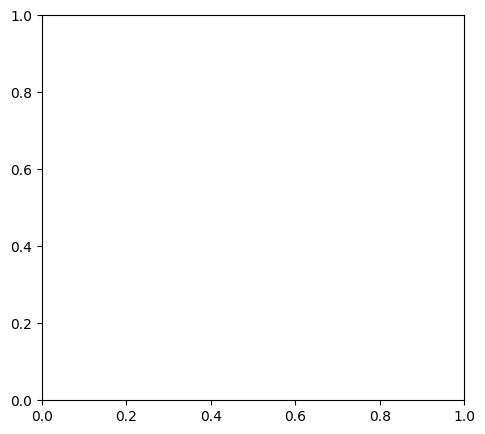

In [ ]:
import matplotlib.pyplot as plt
# 에포크 수 정의
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 5))

# 1. 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')  # 'train_losses' 사용
plt.plot(epochs, test_losses, label='Test Loss', marker='o')    # 'test_losses' 사용
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## [MY CODE] 번역 테스트

In [ ]:
def translate(model, tokenizer, text, max_length=128):
    """
    번역을 수행하는 함수.
    Args:
        model: 번역에 사용되는 모델.
        tokenizer: 텍스트를 토큰화하는 데 사용되는 토크나이저.
        text (str): 번역할 텍스트.
        max_length (int): 생성할 텍스트의 최대 길이. 기본값은 128.

    Returns:
        str: 번역된 텍스트.
    """

    # 텍스트를 모델 입력 형식에 맞게 토큰화합니다.
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(model.device)

    # 모델을 사용하여 번역을 생성합니다.
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length,
            num_beams=5,  # 빔 서치 전략을 사용할 경우
            early_stopping=True
        )

    # 생성된 토큰을 다시 텍스트로 디코딩합니다.
    translated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return translated_text


# 번역 테스트 예제
text = "This is a test sentence."
translated_text = translate(model, tokenizer, text)  # model과 tokenizer 사용
print(f"Original: {text}")
print(f"Translated: {translated_text}")


## Q1) 어떤 task를 선택하셨나요?
> 기계 번역 (Machine Translation)
## Q2) 모델은 어떻게 설계하셨나요? 설계한 모델의 입력과 출력 형태가 어떻게 되나요?
> Transformer 기반의 Encoder-Decoder 모델, 입력: input_ids, 출력: logits


## Q3) 어떤 pre-trained 모델을 활용하셨나요?
> MarianMT 모델 (다국어 기계 번역에 적합)


## Q4) 실제로 pre-trained 모델을 fine-tuning했을 때 loss curve은 어떻게 그려지나요? 그리고 pre-train 하지 않은 Transformer를 학습했을 때와 어떤 차이가 있나요?
> Pre-trained 모델을 fine-tuning한 경우 손실 곡선이 빠르게 감소하며, BLEU Score와 같은 성능 지표에서 더 높은 성능을 보입니다. Pre-trained 모델 없이 학습할 경우 느린 수렴과 낮은 성능을 보일 수 있습니다.